# Testing new repo structure
Last modified March 18

The goal of this notebook is to serve as a preliminary example doing a PINNs inversion with the current setup.

First, we import the relevant libraries

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

# Go up 3 levels to the repo's root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add the repo root to sys.path
sys.path.append(repo_root)

from data_processing.helpers import normalize, sample, init_single_net, neural_net
from data_processing.load_data_functions import load_elmer_results

Next, we load in our data. This is a custom function, stored in the data_processing folder. The results are standardized though!

In [2]:
csv = '../../elmer_results/results/pvm.csv'
df_filtered, df_surface, df_divide, df_bed, df_flanks = load_elmer_results(csv,0,4000)

Everything is loaded! Next, we initialize the PINN for our problem. 

Testing code

In [3]:
def init_pinns(parent_key, n_hl, n_unit): 
    # This should be general! Try to get solution/loss functions to adapt to this
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''

    # set the neural network shape for u, w
    layers1 = [2] + n_hl * [n_unit] + [2] 

    # set the neural network shape for p, mu
    layers2 = [2] + n_hl * [n_unit] + [2] 

    # generate the random key for each network
    keys = random.split(parent_key, 3)
    
    # generate weights and biases for density
    params_uw = init_single_net(keys[0], layers1)
    params_pmu = init_single_net(keys[1], layers2)

    params_rho = random.truncated_normal(keys[2], -2, 2, shape=(2,)) # 2 params rho_s and L

    return [params_uw, params_rho, params_pmu]

In [4]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [5]:
# normalize
df_norm,df_bcs,info = normalize(df_filtered, df_surface, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [6]:
def create_solution(df_surf,scl=1, act_s=0):
    # this should also be a general function!
    # df_surf is nondimensional
    x_s = df_surf['x'].values
    z_s = df_surf['z'].values
    
    def f(params,x):
        x0, z0 = jnp.split(x, 2, axis=1)
        uw = neural_net(params[0], x, scl, act_s)
        pm_rho = params[1]
        H = jnp.interp(x0,x_s,z_s)  
        rho = 1 + (jnp.exp(pm_rho[0]) - 1) * jnp.exp((-H+z0)/jnp.exp(pm_rho[1]))
        pmu = neural_net(params[2], x, scl, act_s)
        sol = jnp.hstack([uw,rho,pmu])
        return sol
    return f

The loss function is where i will whittle down data into relevant bits. This way I can use multiple equations. Equations also have to fit the generalized data structure. Initializing the solution function has to be a general thing as well then.

In [7]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


Now we make our samples for Adam and L-BFGS. For this simple mass conservation, we need the boundaries at the bed, divide, and surface.

In [8]:
# for adam
n_samples = jnp.array([400,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

Assuming that we have defined our equations properly, now we need to define our loss function (i.e. the function to create the loss function). This is the custom function that lies within the notebook

In [9]:
from equations.simple_mass_conservation import gov_eqn

In [10]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_masscon(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        w_smp = data['smp'][1][:,1:2] # ground truth w
        x_div = data['div'][0]
        u_div = data['div'][1][:,0:1] # horizontal velocity at divide (should be 0)
        x_bed = data['bed'][0]
        w_bed = data['bed'][1][:,1:2] # ground truth w at bed (should be 0)
        rho_bed = data['bed'][1][:,2:3] # ground truth rho at bed (should be rho_i)
        x_surf = data['surf'][0]
        u_surf = data['surf'][1][:,0:1] # ground truth surface horizontal velocity 

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        w_pred = net(x_smp)[:, 1:2] # not 0:2 because we only have data in w

        # boundary constraints
        u_div_pred = net(x_div)[:,0:1]
        bed_pred = net(x_bed)
        w_bed_pred = bed_pred[:,1:2]
        rho_bed_pred = bed_pred[:,2:3]
        u_surf_pred = net(x_surf)[:,0:1]
        
        # calculate the residue of equation
        f_pred = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(w_pred - w_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        div_err = ms_error(u_div_pred-u_div)
        rho_bed_err = ms_error(rho_bed-rho_bed_pred)
        w_bed_err = ms_error(w_bed-w_bed_pred)
        surf_err = ms_error(u_surf-u_surf_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(div_err) + jnp.sum(rho_bed_err) + jnp.sum(w_bed_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, div_err, rho_bed_err, w_bed_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [11]:
# create the loss function
NN_loss = create_loss_masscon(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [12]:
from models.optimization import adam_optimizer, lbfgs_optimizer

In [13]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 8.4415e-02 | Loss_d: 2.0794e-01 | Loss_e: 7.0678e-02 | Loss_b: 4.7791e+00
Step: 200 | Loss: 2.4810e-02 | Loss_d: 1.5597e-01 | Loss_e: 6.4962e-02 | Loss_b: 1.2655e+00
Step: 300 | Loss: 1.1304e-02 | Loss_d: 1.3005e-01 | Loss_e: 6.9292e-02 | Loss_b: 4.7791e-01
Step: 400 | Loss: 5.4955e-03 | Loss_d: 7.2261e-02 | Loss_e: 4.0905e-02 | Loss_b: 2.1609e-01
Step: 500 | Loss: 2.8428e-03 | Loss_d: 3.6588e-02 | Loss_e: 1.9604e-02 | Loss_b: 1.1413e-01
Step: 600 | Loss: 1.8271e-03 | Loss_d: 2.2314e-02 | Loss_e: 1.9262e-02 | Loss_b: 6.7893e-02
Step: 700 | Loss: 1.1398e-03 | Loss_d: 1.3088e-02 | Loss_e: 1.0663e-02 | Loss_b: 4.4541e-02
Step: 800 | Loss: 7.3233e-04 | Loss_d: 7.5802e-03 | Loss_e: 1.0102e-02 | Loss_b: 2.6195e-02
Step: 900 | Loss: 5.0337e-04 | Loss_d: 6.4076e-03 | Loss_e: 6.1370e-03 | Loss_b: 1.7614e-02
Step: 1000 | Loss: 3.7416e-04 | Loss_d: 5.6787e-03 | Loss_e: 3.8494e-03 | Loss_b: 1.2889e-02
Step: 1100 | Loss: 2.9319e-04 | Loss_d: 4.7396e-03 | Loss_e: 3.2989e-03 | Loss_

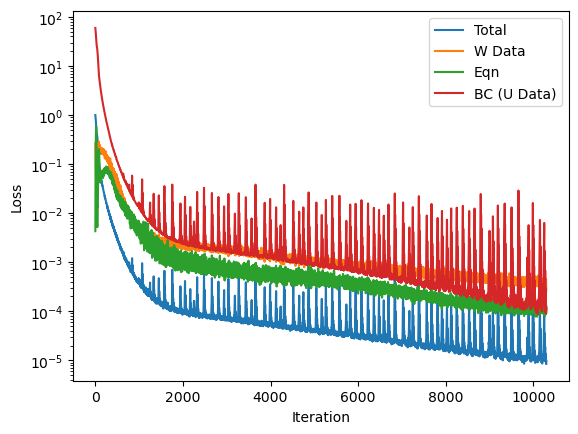

In [14]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [15]:
# set the training iteration
epoch2 = 5000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 1.0945e-05 | Loss_d: 4.3849e-04 Loss_e: 1.0742e-04 | Loss_b: 1.0987e-04
Step: NaN | Loss: 4.7770e-05 | Loss_d: 4.0211e-04 Loss_e: 1.1179e-04 | Loss_b: 2.3482e-03
Step: NaN | Loss: 1.0616e-05 | Loss_d: 4.3470e-04 Loss_e: 1.0753e-04 | Loss_b: 9.3827e-05
Step: NaN | Loss: 1.0511e-05 | Loss_d: 4.3236e-04 Loss_e: 1.0778e-04 | Loss_b: 8.9593e-05
Step: NaN | Loss: 1.1609e-05 | Loss_d: 4.2386e-04 Loss_e: 1.0938e-04 | Loss_b: 1.6230e-04
Step: NaN | Loss: 1.0508e-05 | Loss_d: 4.3192e-04 Loss_e: 1.0784e-04 | Loss_b: 8.9808e-05
Step: NaN | Loss: 1.0484e-05 | Loss_d: 4.2924e-04 Loss_e: 1.0785e-04 | Loss_b: 9.1059e-05
Step: NaN | Loss: 1.0424e-05 | Loss_d: 4.1929e-04 Loss_e: 1.0796e-04 | Loss_b: 9.7297e-05
Step: NaN | Loss: 1.0939e-05 | Loss_d: 3.8778e-04 Loss_e: 1.0937e-04 | Loss_b: 1.5828e-04
Step: NaN | Loss: 1.0414e-05 | Loss_d: 4.1386e-04 Loss_e: 1.0805e-04 | Loss_b: 1.0204e-04
Step: NaN | Loss: 1.0388e-05 | Loss_d: 4.1095e-04 Loss_e: 1.0716e-04 | Loss_b: 1.0430e-04
Step: NaN 

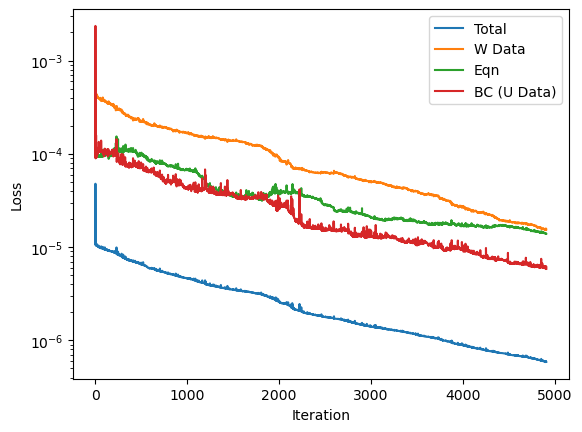

In [17]:
plot_loss(loss2)

In [24]:
# now lets make a prediction
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

#x_pred

In [25]:
x_pred = df_norm[['x','z']].values

In [26]:
uw_rho_pmu = f_u(x_pred)


In [28]:
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)

!!! Loss function needs to output terms! Important for prediction

In [58]:
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_filtered[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
results['x'] = df_filtered['x'].values
results['z'] = df_filtered['z'].values